Import required libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
## limit the number of decimal places printed in output of numpy objects
np.set_printoptions(precision=3)  

Set up the matrix $M$ as a two-dimensional array: `((a11,a12,...),(a21,a22,...),...,(an1,an2))` (the third set of parentheses belongs to the `np.array()` function).

In [3]:
M = np.array(((0,0,0,0,0,322.38),
              (0.966,0,0,0,0,0),
              (0.013,0.010,0.125,0,0,3.448),
              (0.007,0,0.125,0.238,0,30.17),
              (0.008,0,0,0.245,0.167,0.862),
              (0,0,0,0.023,0.75,0)))
print(M)

[[  0.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00   3.224e+02]
 [  9.660e-01   0.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  1.300e-02   1.000e-02   1.250e-01   0.000e+00   0.000e+00   3.448e+00]
 [  7.000e-03   0.000e+00   1.250e-01   2.380e-01   0.000e+00   3.017e+01]
 [  8.000e-03   0.000e+00   0.000e+00   2.450e-01   1.670e-01   8.620e-01]
 [  0.000e+00   0.000e+00   0.000e+00   2.300e-02   7.500e-01   0.000e+00]]


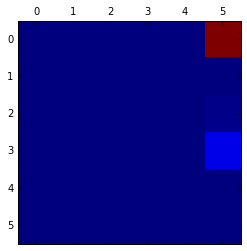

In [5]:
%matplotlib inline
plt.matshow(M)

In [26]:
start = np.array((1,0,0,0,0,0))

The simple way to solve this computationally is with a `for` loop:

In [33]:
x = start
for t in range(200):
    x = M.dot(x)
print(x)

[  9.707e+71   4.039e+71   1.856e+70   1.056e+71   1.841e+70   6.992e+69]


We can do the same thing with a matrix-power operator: first we compute $M^200$, then multiply it by $x(0)$ (we could do it all in one step):

In [36]:
M200 = np.linalg.matrix_power(M,200)
x200 = M200.dot(start)
print(x200)


[  9.707e+71   4.039e+71   1.856e+70   1.056e+71   1.841e+70   6.992e+69]


True

The results are visually the same as before (we could use `np.allclose(x,x200)` to check that all of the elements are nearly identical - we don't expect them to be exactly the same, because floating-point computations are involved).

Calculate eigenvalues and eigenvectors:

In [51]:
e1 = np.linalg.eig(M)

Print the eigenvalues (numpy returns the eigenvalues as a complex-valued array: it uses `j` to indicate the square root of -1) 

In [39]:
e1[0]

array([ 2.322+0.j   , -0.957+1.489j, -0.957-1.489j,  0.142+0.198j,
        0.142-0.198j, -0.162+0.j   ])

Compute the modulus of the eigenvalues:

In [40]:
np.abs(e1[0])

array([ 2.322,  1.77 ,  1.77 ,  0.244,  0.244,  0.162])

In [59]:
np.abs(e1[0][1]/e1[0][0])


0.7622542516174049

In [49]:
def zapsmall_im(x,tol=1e-8):
    """return Re(x) if imaginary part is small"""
    if all(abs(np.imag(x))<tol):
        return(np.real(x))
    return(x)

In [50]:
eigvec0 = e1[1][:,0]/np.sum(e1[1][:,0])
zapsmall_im(eigvec0)

array([ 0.637,  0.265,  0.012,  0.069,  0.012,  0.005])

Now run the model again, but keep track of the values for all time steps:

In [55]:
tvec = np.arange(50)
x = np.zeros((len(tvec),len(start)))  ## set up space for results
x[0,:] = start
for t in tvec[1:]:
        x[t,:] = M.dot(x[t-1,:])

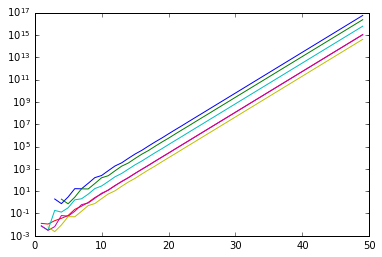

In [56]:
%matplotlib inline
plt.semilogy(tvec,x);  ## "semi-log-y" (i.e. y is on the log scale)

[broadcasting rules](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html)

In [57]:
rowsums = np.sum(x,axis=1)
rowtab = rowsums[:,np.newaxis]

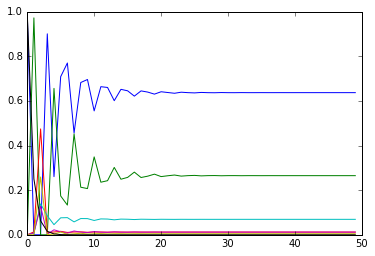

In [58]:
%matplotlib inline
plt.plot(tvec,x/rowtab);
## plt.plot(tvec,0.25**tvec)